dc     dc    da2   dz2 <br>
---  = --- . --- . --- <br>
dw2    da2   dz2   dw2 <br>
z2 = a1w2 + b2 <br>
a2 = softmax(z2)<br>
dz2/dw2 = a1<br>
da2/dz2 = softmax derivative(z2)<br>
dc/da2  = cost function derivative(a2) = -y/a2<br>
w2 = w2- dc/dw2

In [162]:
import tensorflow as tf
from sklearn import datasets
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [163]:
iris = datasets.load_iris()
train_f, test_f, train_l, test_l = train_test_split(iris['data'], iris['target'], random_state= 42 )

In [164]:
train_f = tf.convert_to_tensor(train_f, dtype=tf.float32)
train_l = tf.one_hot(train_l,depth=3, dtype=tf.float32)

test_f = tf.convert_to_tensor(test_f, dtype=tf.float32)
test_l = tf.one_hot(test_l,depth=3, dtype=tf.float32)

display(train_f.shape)
display(type(train_f))

TensorShape([112, 4])

tensorflow.python.framework.ops.EagerTensor

In [165]:
def get_acc(x, y):
    acc = 0
    s = list(zip(x.numpy(),tf.argmax(y, axis=1).numpy()))
    for i in range(len(s)):
      if s[i][0]== s[i][1]:
        acc +=1
    return acc/len(s)*100

def sigmoid(s):
  return 1/(1 + tf.math.exp(-s))

def cross_entropy(pred, real):
  '''Usually it would require Jacobian matrix to calculate d(C)/d(a2) * d(a2)/d(z2),
  but as per this article explaining te math behind it http://neuralnetworksanddeeplearning.com/chap3.html#introducing_the_cross-entropy_cost_function , we will use that d(C)/d(a2) * d(a2)/d(z2) = a2-y .
  then we divide the result (derivative) of each observation to the number of observations, that would linearly decrease the derivative value preventing from gradient expolsion (this is a kinf of regularization).
  It has also other benefits, nicel;y explained here:
  https://stackoverflow.com/questions/65275522/why-is-softmax-classifier-gradient-divided-by-batch-size-cs231n#:~:text=It's%20because%20you%20are%20averaging,regularization%20(to%20avoid%20overfitting).


  '''
  n_samples = real.shape[0]
  res = pred - real
  return res/n_samples
  # you can test it without regularization res/n_samples, and will see that w2 becomes really high and w1 really low and we loose it all. all predictions get stuck at 33%
  ## I didnt manage to go deeper into the need of this regularization, but it works
  ## print('cross entropy',res/n_samples)
  # return res

def error(pred, real):
  '''this calculates the cross-entropy loss.
  i had to use some additional functions to make it compatible with temsorflow. returns the Loss for all observations, this is why it is devided by the number of observations.
  '''
  n_samples = real.shape[0]
  k = list(map(list, zip(tf.range(n_samples), tf.argmax(real, axis=1))))
  logp = - tf.math.log(tf.gather_nd(pred, indices=np.array(k)))
  loss = tf.math.reduce_sum(logp)/n_samples
  return loss.numpy()

def softmax(s):
  ''' Softmax activation function, from each value we substract the maximum probability for this observation , this way it is more normalized and may avoid exploding gradients
  '''
  return (tf.math.exp(s - np.max(s, axis=1, keepdims=True)))/tf.math.reduce_sum((tf.math.exp(s - np.max(s, axis=1, keepdims=True))), axis=1, keepdims=True)


def relu(s):
  ''' this is a Relu activation'''
  return tf.math.maximum(0.0, s)


class TomasNN:
  '''thisis the main lerning model. it has only 1 hidden layer.
  x -> input data (must be tensor)
  y -> target, labels  (must be tensor, and One hot encoded)
  neurons -> number of nodes in the hidden layer

  '''
  def __init__(self, x, y, neurons):
    self.act_func = {'sigmoid' : sigmoid, 'softmax' : softmax, 'relu' : relu}
    self.x = x
    self.y = y
    self.neurons = neurons
    ip_dim = self.x.shape[1]
    op_dim = self.y.shape[1]



    self.w1 = tf.random.normal([ip_dim,self.neurons], mean=1.0, stddev= 0.1, dtype=tf.dtypes.float32)
    self.b1 = tf.zeros([1,self.neurons], dtype=tf.dtypes.float32)
    self.w2 = tf.random.normal([self.neurons, op_dim], mean=1.0, stddev= 0.1, dtype=tf.dtypes.float32)
    self.b2 = tf.zeros([1,op_dim], dtype=tf.dtypes.float32)



  def feedforward(self, l_active = 'relu', op_active = 'softmax'):
    '''we can choose between 3 acivation functions: relu , sigmoid, softmax
    l_active -> activation function for the hidden layer  (default = relu)
    op_active -> activation function for teh output layer (default = softmax)

    '''
    self.l_active = self.act_func[l_active]
    self.op_active = self.act_func[op_active]

    self.z1 = tf.matmul(self.x, self.w1) + self.b1
    self.a1 = self.l_active(self.z1)
    self.a1 = tf.convert_to_tensor(self.a1, dtype=tf.float32)


    self.z2 = tf.matmul(self.a1, self.w2) + self.b2
    self.a2 = self.op_active(self.z2)
    self.a2 = tf.convert_to_tensor(self.a2, dtype=tf.float32)

    # self.loss = error(self.a2, self.y)

  def backprop(self, lr=0.1):
    '''
    all of the parameters here could be called after the training for monitoring purposses
    lr -> learning rate (default = 0.1)
    '''
    self.loss = error(self.a2, self.y)

    # print('Error: ', self.loss)

    self.delta_a2 = cross_entropy(self.a2, self.y)
    self.delta_w2 = tf.tensordot(tf.transpose(self.a1),self.delta_a2,axes=1)
    self.delta_b2 = tf.math.reduce_sum(self.delta_a2)

    with tf.GradientTape() as g:

        g.watch(self.z1)
        self.delta_z1 = tf.tensordot(self.delta_a2,tf.transpose(self.w2),axes=1)
        self.delta_a1 = self.delta_z1*g.gradient(self.l_active(self.z1), self.z1)
        self.delta_w1 = tf.tensordot(tf.transpose(self.x),self.delta_a1,axes=1)

    with tf.GradientTape() as gg:
        gg.watch(self.z1)
        self.delta_b1 = tf.math.reduce_sum(self.delta_a1)



    self.w2 = self.w2 - lr*self.delta_w2
    self.b2 = self.b2 - lr*self.delta_b2
    self.w1 = self.w1 - lr*self.delta_w1
    self.b1 = self.b1 - lr*self.delta_b1

    return self.loss

  def predict(self, data):
    ''' this prediction function replaces the input from teh previos call of the model
    '''
    self.x = data
    self.feedforward()
    return tf.argmax(self.a2, axis=1)


In [166]:
model = TomasNN(x = train_f,y = train_l, neurons = 6)
loss_to_plot = []

In [167]:
for i in range(300):
  model.feedforward()
  loss_to_plot.append(model.backprop(lr = 0.1))

In [168]:
predicted = model.predict(test_f)

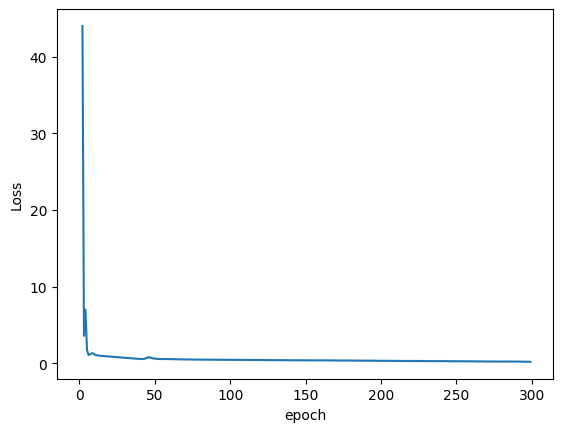

In [169]:
plt.plot(loss_to_plot)
plt.xlabel(xlabel = 'epoch')
plt.ylabel(ylabel = 'Loss')
plt.show()

In [170]:
print(f'Accuracy:{get_acc(predicted,test_l):.2f}%')



Accuracy:89.47%
